# Can Synthetic Data Replace Real Data

### Goal
The goal of this project is to rigorously evaluate whether synthetic tabular data can replace real data for supervised learning tasks. The primary contribution is empirical: identifying when synthetic data matches/supplements/fails to replace real data.

### Core question
Under what conditions does training on synthetic tabular data achieve comparable performance to training on real tabular data?

## Imports and data loading

In [70]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn methods and classes
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, average_precision_score # For AUPRC
from sklearn.compose import ColumnTransformer

# We don't use sklearn Pipeline because sklearn's Pipeline expects .fit_transform() method
# imblearn doesn't have .fit_transform(), it has .fit_resample()
# So we'll use imblearn's Pipeline implementation instead
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

 # For SMOTE
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTEN, SMOTENC
# For resampling
from imblearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# For DatasetMetaData
from dataclasses import dataclass

# For displaying pipelines side by side
from IPython.display import display, HTML

# For saving results
from pathlib import Path

# For logging version numbers
from importlib.metadata import version

# For logging date
from datetime import datetime


In [71]:
gimme_some_credit_train = pd.read_csv("datasets/cs-training.csv")
default_credit_df = pd.read_csv("datasets/UCI_Credit_Card.csv")
adult_census_income_df = pd.read_csv("datasets/adult.csv")

## Exploratory Data Analyses

### Give Me Some Credit EDA
Note that this is not the dataset proposed in the original paper. That dataset was a replica of a competition, which was in turn a subset of another competition's data. This dataset is a copy of the orgininal competition's data.

Note that `SeriousDlqin2yrs` is the target feature, thus is having no values in
the `test` DataFrame.

In [72]:
gimme_some_credit_train.drop('Unnamed: 0', axis='columns', inplace=True)
gimme_some_credit_train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [73]:
gimme_some_credit_train.info()

<class 'pandas.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtypes: float64(

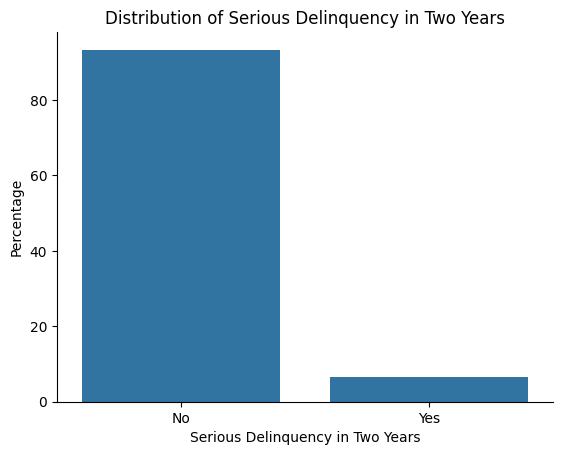

In [74]:
ax = sns.countplot(x='SeriousDlqin2yrs',
                   data=gimme_some_credit_train,
                   stat='percent');
ax.set_title('Distribution of Serious Delinquency in Two Years')
ax.set_xlabel('Serious Delinquency in Two Years');
ax.set_ylabel('Percentage');
ax.set_xticks([0, 1]);
ax.set_xticklabels(['No', 'Yes']);
sns.despine()

In [75]:
gimme_some_credit_train[['SeriousDlqin2yrs', 'NumberOfDependents']].groupby('SeriousDlqin2yrs').value_counts()

SeriousDlqin2yrs  NumberOfDependents
0                 0.0                   81807
                  1.0                   24381
                  2.0                   17938
                  3.0                    8646
                  4.0                    2565
                  5.0                     678
                  6.0                     134
                  7.0                      46
                  8.0                      22
                  9.0                       5
                  10.0                      5
                  20.0                      1
                  13.0                      1
1                 0.0                    5095
                  1.0                    1935
                  2.0                    1584
                  3.0                     837
                  4.0                     297
                  5.0                      68
                  6.0                      24
                  7.0                      

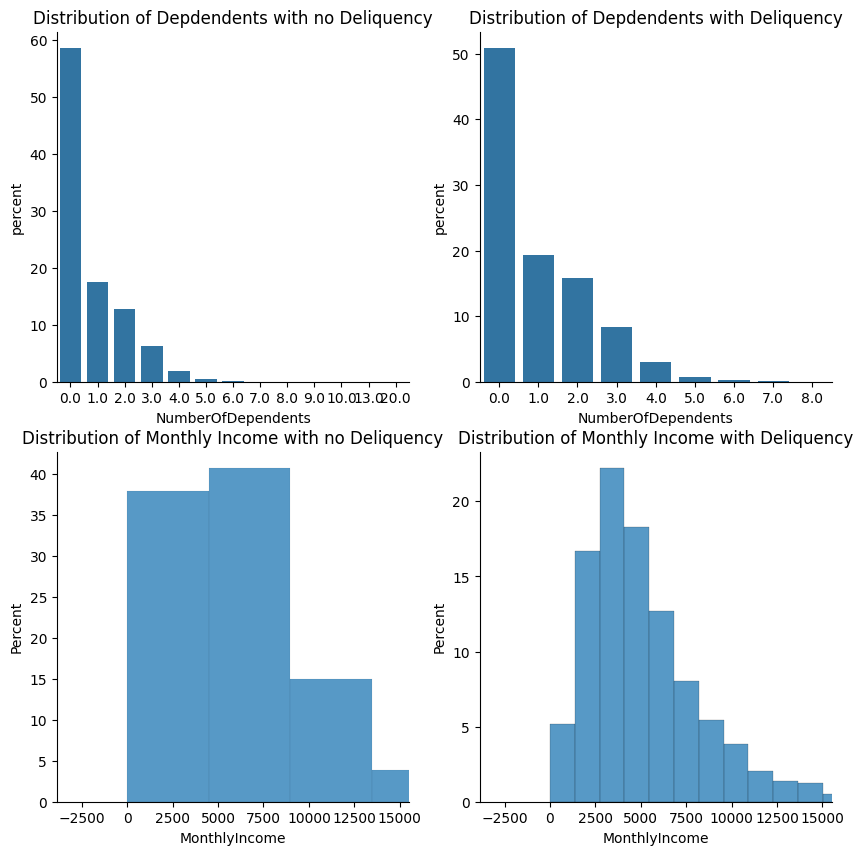

In [76]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

sns.countplot(
    data=gimme_some_credit_train[gimme_some_credit_train['SeriousDlqin2yrs'] == 0],
    x='NumberOfDependents',
    stat='percent',
    ax=ax[0, 0]
);

sns.countplot(
    data=gimme_some_credit_train[gimme_some_credit_train['SeriousDlqin2yrs'] == 1],
    x='NumberOfDependents',
    stat='percent',
    ax=ax[0, 1]
);

# Monthly income varies too widely. Let's find outliers
q1, q3 = gimme_some_credit_train['MonthlyIncome'].quantile(0.25), gimme_some_credit_train['MonthlyIncome'].quantile(0.75)
iqr = q3 - q1
low_val, high_val = q1 - 1.5 * iqr, q3 + 1.5 * iqr

sns.histplot(
    data=gimme_some_credit_train[gimme_some_credit_train['SeriousDlqin2yrs'] == 0],
    x='MonthlyIncome',
    stat='percent',
    ax=ax[1, 0]
);

sns.histplot(
    data=gimme_some_credit_train[gimme_some_credit_train['SeriousDlqin2yrs'] == 1],
    x='MonthlyIncome',
    stat='percent',
    ax=ax[1, 1]
);

ax[0, 0].set_title('Distribution of Depdendents with no Deliquency')
ax[0, 1].set_title('Distribution of Depdendents with Deliquency')
ax[1, 0].set_title('Distribution of Monthly Income with no Deliquency')
ax[1, 1].set_title('Distribution of Monthly Income with Deliquency')

# Limit histograms to ignore outliers

ax[1, 0].set_xlim(low_val, high_val)
ax[1, 1].set_xlim(low_val, high_val)

sns.despine();

**Findings:** Our training data had two features which have missing values:
* `NumberOfDependents`
* `MonthlyIncome`

Based on visual inspection, there does not seem to be a correlation between deliquency and the two features. However, statistical testing should be done to confirm this.

Median imputation seems to be appropiate here.

### Default of Credit Clients EDA

In [77]:
default_credit_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [78]:
default_credit_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   30000 non-null

**Findings**: The Default of Credit Clients dataset has no missing values.

### Adult Census Income EDA

In [79]:
adult_census_income_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [80]:
adult_census_income_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             32561 non-null  int64
 1   workclass       32561 non-null  str  
 2   fnlwgt          32561 non-null  int64
 3   education       32561 non-null  str  
 4   education.num   32561 non-null  int64
 5   marital.status  32561 non-null  str  
 6   occupation      32561 non-null  str  
 7   relationship    32561 non-null  str  
 8   race            32561 non-null  str  
 9   sex             32561 non-null  str  
 10  capital.gain    32561 non-null  int64
 11  capital.loss    32561 non-null  int64
 12  hours.per.week  32561 non-null  int64
 13  native.country  32561 non-null  str  
 14  income          32561 non-null  str  
dtypes: int64(6), str(9)
memory usage: 3.7 MB


**Findings**: The Adult Census Income dataset has no missing values.

## Set-up, Splitting, Preprocessing, and Cross-Validation
As per sections 2.1, 2.2, and 2.3 of the research protocol document:

1. **Set-up:** We study supervised classification under three training regimes: real-only, synthetic-only, and mixed real-plus-synthetic training. All evaluations are performed on real data that is never used during synthetic data generation.

2. **Splitting:** Each dataset is split into a held-out test set (20%) and a development set (80%). Model selection and evaluation on the development set are performed using repeated stratified K-fold cross-validation. All reported results are averaged across folds and repetitions.

3. **Preprocessing:** Numerical features are standardized using statistics computed on the training portion of each fold. Categorical features are encoded using one-hot encoding. Missing values are imputed using simple strategies (median for numerical features, mode for categorical features). All preprocessing steps are fit exclusively on training data within each fold.



### Set-up

We'll want to encapsulate all the info about our datasets (num cols, cat cols, X_train, X_test, etc in one easy place. This will allow for:
* Decluttering of variable names
* Type-hinting
* Future Iterability

We perform this with the below class. We set up info for experiments first.

In [81]:
TEST_PROPORTION, DEVELOPMENT_PROPORTION = 0.8, 0.2
SPLITS, REPEATS = 5, 5

# TODO: Synthetic methods and Data Regimes (3.3 and 3.5)

regimes = ['real', 'synthetic', 'mixed']
models = [LogisticRegression(random_state=42),
          DecisionTreeClassifier(random_state=42),
          # Commented out as of now because it takes forever to train
          # RandomForestClassifier(random_state=42)
          ]

In [82]:
@dataclass
class DatasetMetadata:
  name: str
  dataset: pd.DataFrame
  target_feature_name: str
  num_feature_names: list | str
  cat_feature_names: list | str

  # Initialize all to None
  X_train: pd.DataFrame = None
  X_test: pd.DataFrame = None
  y_train: pd.DataFrame = None
  y_test: pd.DataFrame = None

  def set_splits(self, test_size=0.2, random_state=42) -> None:
    self.X = self.dataset[self.num_feature_names + self.cat_feature_names].copy()
    self.y = self.dataset[self.target_feature_name].copy()

    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
        self.X, self.y,
        test_size=test_size,
        stratify=self.y,
        random_state=random_state
    )

### Splitting
We store instances of our dataset metadata in a list

In [83]:
credit_metadataset = DatasetMetadata(
    name = "Give Me Some Credit",
    dataset = gimme_some_credit_train,
    target_feature_name = "SeriousDlqin2yrs",
    num_feature_names = gimme_some_credit_train.columns.drop(
        "SeriousDlqin2yrs").to_list(),
    cat_feature_names = []
)

default_metadataset = DatasetMetadata(
    name = "Default of Credit Clients",
    dataset = default_credit_df,
    target_feature_name = "default.payment.next.month",
    # Note that ID is an irrelevant variable, and shouldn't be included.
    # default.payment.next.month is the target feature
    num_feature_names = default_credit_df.drop(
        columns=["ID", "SEX", "EDUCATION", "MARRIAGE",
                    "default.payment.next.month"]).columns.to_list(),
    cat_feature_names = ["SEX", "EDUCATION", "MARRIAGE"]
)

census_metadataset = DatasetMetadata(
    name = "Adult Census Income",
    dataset = adult_census_income_df,
    target_feature_name = "income",
    # On the `fnlwgt` feature (final weight)
    # From https://www.kaggle.com/datasets/uciml/adult-census-income/discussion/32698
    # "Its a weight assigned by the Census Bureau. **The idea is that if two
    # samples have the same(or similar) fnlwgt they have similar
    # characteristics, demographically speaking...but it is not standardized
    # across states."
    #
    # Decision: drop variable
    num_feature_names = ["age", "education.num", "capital.gain",
                            "capital.loss", "hours.per.week"],
    cat_feature_names = ["workclass", "education", "marital.status",
                            "occupation", "relationship", "race", "sex",
                            "native.country"]
)

metadatasets_list = [credit_metadataset, default_metadataset, census_metadataset]

To test we have coverage of the columns, the differences should be nuisance features

In [84]:
for instance in metadatasets_list:
  col_names = pd.Index(instance.num_feature_names + \
                       instance.cat_feature_names + \
                       [instance.target_feature_name])
  display(instance.dataset.columns.difference(col_names))


Index([], dtype='str')

Index(['ID'], dtype='str')

Index(['fnlwgt'], dtype='str')

### Preprocessing

In [85]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
     ('standardize', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
     ('encode', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])

def preprocess(num_cols: list[str], cat_cols: list[str]) -> ColumnTransformer:
  """
  Create a ColumnTransformer for our data

  Args:
    num_cols (list of str): List of numerical column names to be
            imputed (median) and standardized.
    cat_cols (list of str): List of categorical column names to be
        imputed (most frequent) and one-hot encoded.

  Returns:
    ColumnTransformer: A preprocessor which imputes via median then standardizes
    numerical columns and imputes via mode then one-hot encodes categorical
    columns.
  """

  preprocessor = ColumnTransformer(transformers=[
      ('cat', cat_pipeline, cat_cols),
      ('num', num_pipeline, num_cols)
  ])

  return preprocessor

## Week 3

#### **Step 1** for week 3: We'll use the gimme some credit dataset.

As done above, we have defined a dataclass to keep track of holdout and development sets, target and input features.

We initialize this below.

In [86]:
RANDOM_SEED = 42

credit_metadataset.set_splits(test_size=0.2, random_state=RANDOM_SEED)

#### **Step 2** for week 3: Create the holdout test once and don't touch it
* 80% development set (for repeated CV)
* 20% final holdout test set (do not use for SMOTE, tuning, or model selection)

In [87]:
development_X, final_holdout_X = credit_metadataset.X_train, credit_metadataset.X_test
development_y, final_holdout_y = credit_metadataset.y_train, credit_metadataset.y_test

# Check that X and y are the same size
if development_X.shape[0] != development_y.shape[0]:
    raise ValueError(f"I messed up the shapes! number of X rows: {development_X.shape[0]} \
number of y rows: {development_y.shape[0]}")

total_size = development_X.shape[0] + final_holdout_X.shape[0]

if development_X.shape[0] / total_size != 0.8:
    raise ValueError(f"I messed up the train-test split proportion! number of X rows: \
{development_X.shape[0]}, total size: {total_size}")

#### **Step 3** for week 3: Set up repeated stratified cross-validation (the core of leakage safety)
* Use RepeatedStratifiedKFold (example: 5 folds by 2 repeats).
* Fix random seeds so results are reproducible.
* Important: every fold must have its own training-only preprocessing and training-only resampling.

In [88]:
FOLDS, REPEATS = 5, 2

cv_strategy = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=REPEATS,
                                      random_state=RANDOM_SEED)
cv_strategy

RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=42)

#### **Step 4** for week 3: Build **one** leakage-safe pipeline per model using an imblearn Pipeline
The key rule: SMOTE must happen ONLY on the training fold, and only after any transformations that affect distance.
For Week 3 (numeric dataset), use this pipeline structure:
* Imputation (median)
* Scaling (standardize)
* Resampling (None vs RandomOverSampler vs SMOTE)
* Model

Do NOT:
* Fit the scaler/imputer on the full dataset
* Apply SMOTE before splitting into folds
* Apply SMOTE to the validation fold or holdout set




In [89]:
base_credit_pipeline = Pipeline(steps=[
                            ("impute", SimpleImputer(strategy="median")),
                            ("standardize", StandardScaler())
                        ])

base_credit_pipeline

,steps,"[('impute', ...), ('standardize', ...)]"
,transform_input,None
,memory,None
,verbose,False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If a feature has nomissing values at fit/train time, the feature won't appear onthe missing indicator even if there are missing values attransform/test time.",False
,"keep_empty_features keep_empty_features: bool, default=FalseIf True, features that consist exclusively of missing values when`fit` is called are returned in results when `transform` is called.The imputed value is always `0` except when `strategy=""constant""`in which case `fill_value` will be used instead... versionadded:: 1.2",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True


#### **Step 5** for week 3: Implement the three resampling conditions (your baseline rows)
For each model, run all three:
* None (no resampling)
* Random oversampling (RandomOverSampler)
* SMOTE (default k_neighbors=5 is fine for now; no tuning yet)

In [90]:
# For storing pipelines with sampling
credit_pipelines_with_sampling = []
sampling_techniques = [None,
                      RandomOverSampler(random_state=RANDOM_SEED),
                      SMOTE(k_neighbors=5, random_state=RANDOM_SEED)]

sampling_techniques

[None, RandomOverSampler(random_state=42), SMOTE(random_state=42)]

In [91]:
for technique in sampling_techniques:
    credit_pipelines_with_sampling.append(
        Pipeline(steps=base_credit_pipeline.steps + [("sampling_technique", technique)])
    )

# We use this code to display the current pipeline side by side
html_str = ''.join([f'<div style="flex: 1; padding: 5px;">{p._repr_html_()}</div>' for p in credit_pipelines_with_sampling])
display(HTML(f'<div style="display: flex; flex-direction: row;">{html_str}</div>'))

,steps,"[('impute', ...), ('standardize', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If a feature has nomissing values at fit/train time, the feature won't appear onthe missing indicator even if there are missing values attransform/test time.",False
,"keep_empty_features keep_empty_features: bool, default=FalseIf True, features that consist exclusively of missing values when`fit` is called are returned in results when `transform` is called.The imputed value is always `0` except when `strategy=""constant""`in which case `fill_value` will be used instead... versionadded:: 1.2",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True


#### **Step 6** for week 3: Train at least two models (keep it minimal but meaningful)
Run these two this week:
* Logistic Regression (use probability output)
* Random Forest (use probability output)

No hyperparameter tuning in Week 3 beyond basic defaults; we want a clean baseline first.

In [92]:
# We create a list to hold all pipelines with sampling AND models
credit_pipelines_with_models_sampling = []
models = [LogisticRegression(random_state=RANDOM_SEED),
          RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)
          ]

for m in models:
    for p in credit_pipelines_with_sampling:
        credit_pipelines_with_models_sampling.append(
            Pipeline(steps=p.steps + [("clf", m)])
        )

# We use this code to display the pipelines with models side by side
html_str = ''.join([f'<div style="flex: 1; padding: 5px;">{p._repr_html_()}</div>' for p in credit_pipelines_with_models_sampling])
display(HTML(f'<div style="display: flex; flex-direction: row;">{html_str}</div>'))

,steps,"[('impute', ...), ('standardize', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If a feature has nomissing values at fit/train time, the feature won't appear onthe missing indicator even if there are missing values attransform/test time.",False
,"keep_empty_features keep_empty_features: bool, default=FalseIf True, features that consist exclusively of missing values when`fit` is called are returned in results when `transform` is called.The imputed value is always `0` except when `strategy=""constant""`in which case `fill_value` will be used instead... versionadded:: 1.2",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True


#### **Update for week 4**: Since we have the results, we'll add a check to make sure we have the results file.
If we do, we'll skip steps / modify them to save compute time / redundant model training.

In [93]:
output_dir = Path("results")
results_file = output_dir / "baseline_results 01-29.csv"

#### **Step 7** for week 3: Compute the correct metrics on the validation fold

For each fold, evaluate on the validation split (real data only):
* AUROC (`roc_auc_score`)
* AUPRC (`average_precision_score`)

Use predicted probabilities (or decision scores) computed on the validation fold.

In [94]:
# Modification for week 4, we should already have the results file, so perform a check
# and if so, don't do anything
if results_file.exists():
    pass
else:

    rows_list = []
    scoring_metrics = ['roc_auc', 'average_precision']

    for p in credit_pipelines_with_models_sampling:
        model_name = p[-1].__class__.__name__

        print(f"working with model {model_name} on {p["sampling_technique"]}\n")

        scores = cross_validate(
            p,
            development_X,
            development_y,
            cv=cv_strategy,
            scoring=scoring_metrics,
            n_jobs=-1
        )

        auroc_mean = scores["test_roc_auc"].mean()
        auroc_std = scores["test_roc_auc"].std()
        prroc_mean = scores["test_average_precision"].mean()
        prroc_std = scores["test_average_precision"].std()

        row_dict = {   
            "Resampling"    :   str(p["sampling_technique"]),
            "Model"         :   str(p["clf"]),
            "AUROC mean"    :   auroc_mean,
            "AUROC std"     :   auroc_std,
            "PRROC mean"    :   prroc_mean,
            "PRCOS std"     :   prroc_std
        }

        rows_list.append(row_dict)


#### **Step 8** for week 3: Produce the baseline table

Create a small table with mean ± standard deviation across all folds/repeats:
Rows: None, RandomOverSampler, SMOTE
Columns: Model name, AUROC (mean ± std), AUPRC (mean ± std)

Example structure (you can format it however you like):
Resampling | Model | AUROC (mean±std) | AUPRC (mean±std)

In [95]:
# Modification for week 4, we should already have the results file, so perform a check
# and if so, make baseline_table read from the results file
if results_file.exists():
    baseline_table = pd.read_csv(results_file)
else:
    baseline_table = pd.DataFrame(rows_list)

baseline_table

,Resampling,Model,AUROC mean,AUROC std,PRROC mean,PRCOS std
0,NaN,LogisticRegression(random_state=42),0.693636,0.008474,0.234006,0.006874
1,RandomOverSampler(random_state=42),LogisticRegression(random_state=42),0.789305,0.004017,0.305749,0.010198
2,SMOTE(random_state=42),LogisticRegression(random_state=42),0.780450,0.003851,0.293179,0.009495
3,NaN,"RandomForestClassifier(n_jobs=-1, random_state...",0.837737,0.003945,0.353923,0.006070
4,RandomOverSampler(random_state=42),"RandomForestClassifier(n_jobs=-1, random_state...",0.834684,0.004937,0.326611,0.005276
5,SMOTE(random_state=42),"RandomForestClassifier(n_jobs=-1, random_state...",0.824020,0.003741,0.297881,0.007071


#### **Step 9** for week 3: Add two quick sanity checks (these prevent "quiet" mistakes)
For ONE fold, print class counts:

    y_train before resampling
    y_train after resampling
    y_valid (should never change)

Confirm that the number of validation samples is unchanged and that resampling is not applied to validation/test.

In [96]:
# Get the first fold's indices from RepeatedStratifiedKFold
train_ix, val_ix = next(cv_strategy.split(development_X, development_y))

# Using the index, we split the data manually
X_train_fold, X_val_fold = development_X.iloc[train_ix], development_X.iloc[val_ix]
y_train_fold, y_val_fold = development_y.iloc[train_ix], development_y.iloc[val_ix]

# Print the value counts of y_train before resampling
display("The value counts of `y_train_fold` before resampling:")
display(y_train_fold.value_counts())

# Print the value counts of y_valid before resampling
display("The value counts of `y_val_fold` before resampling:")
display(y_val_fold.value_counts())

display('-' * 6 + 'Testing proportions with resampling' + '-' * 6)

# To test resampling, we'll use the second and third credit pipelines (indices 1 and 2) which use
# RandomOverSampler and SMOTE respectively
for i in range(1, len(credit_pipelines_with_sampling)):
    curr_pipeline = credit_pipelines_with_sampling[i]
    sampler_name = curr_pipeline[-1].__class__.__name__

    display(f"Working with {sampler_name}")

    X_fold_resampled, y_fold_resampled = curr_pipeline.fit_resample(X_train_fold, y_train_fold)

    display(' ' * 4 + f"The value counts of `y_train` with resampling:")
    display(y_fold_resampled.value_counts())

    display(' ' * 4 + "The value counts of `y_val_fold` after resampling:")
    display( y_val_fold.value_counts())




'The value counts of `y_train_fold` before resampling:'

SeriousDlqin2yrs
0    89583
1     6417
Name: count, dtype: int64

'The value counts of `y_val_fold` before resampling:'

SeriousDlqin2yrs
0    22396
1     1604
Name: count, dtype: int64

'------Testing proportions with resampling------'

'Working with RandomOverSampler'

'    The value counts of `y_train` with resampling:'

SeriousDlqin2yrs
0    89583
1    89583
Name: count, dtype: int64

'    The value counts of `y_val_fold` after resampling:'

SeriousDlqin2yrs
0    22396
1     1604
Name: count, dtype: int64

'Working with SMOTE'

'    The value counts of `y_train` with resampling:'

SeriousDlqin2yrs
0    89583
1    89583
Name: count, dtype: int64

'    The value counts of `y_val_fold` after resampling:'

SeriousDlqin2yrs
0    22396
1     1604
Name: count, dtype: int64

**Confirmation**: The value counts of `y_val_fold` are the same before and after sampling

#### **Step 10** for week 3: Save outputs for reproducibility
* Save the baseline table to a CSV (and/or LaTeX table snippet).
* Log the random seed and library versions (sklearn, imblearn).
* Keep results in a results/ folder so we can reference them later.

In [97]:
# Modification for week 4, we should already have the results file, so perform a check
# and if so, don't do anything
if results_file.exists():
    pass
else:
    output_dir = Path("results")
    output_file = output_dir / f"baseline_results {datetime.now().strftime("%m-%d")}.csv"

    # Make results subdirectory if it doesn't already exist
    output_dir.mkdir(parents=True, exist_ok=True)

    baseline_table.to_csv(output_file, index=False)
    f"Results successfully saved to: {output_file}"

In [98]:
# Modification for week 4, we should already have the results file, so perform a check
# and if so, don't do anything
if results_file.exists():
    pass
else:
    # Saving info about random seed and versions
    info_df = pd.DataFrame({
        "Date:":            [datetime.now().strftime("%m-%d")],
        "Random Seed":      [RANDOM_SEED],
        "sklearn version":  [version("scikit-learn")],
        "imblearn version": [version("imbalanced-learn")]
    })

    # Not using datetime so we don't end up with a 1000 files with the same info
    info_file = output_dir / f"info.csv"
    info_df.to_csv(info_file, index=False)
    f"Results successfully saved to: {info_file}"


#### Cautionary results
Running SMOTE before CV - this is meant to illustrate what NOT to do.

In [99]:
# Modification for week 4, we should already have the results file, so perform a check
# and if so, don't do anything
if results_file.exists():
    pass
else:
    # The pipeline with SMOTE is the last
    smote_pipeline = credit_pipelines_with_sampling[-1]

    # Running SMOTE before CV
    X_bad, y_bad = smote_pipeline.fit_resample(development_X, development_y)

    # To store bad results
    bad_results = []

    scores = cross_validate(
        # Only using Logistic Regression because RFC takes forever to run
        LogisticRegression(random_state=42),
        X_bad,
        y_bad,
        cv=cv_strategy,
        scoring=scoring_metrics,
        n_jobs=-1
    )

    auroc_mean = scores["test_roc_auc"].mean()
    auroc_std = scores["test_roc_auc"].std()
    prroc_mean = scores["test_average_precision"].mean()
    prroc_std = scores["test_average_precision"].std()

    bad_dict = {
        "Model"         :   "LogisticRegression",
        "AUROC mean"    :   auroc_mean,
        "AUROC std"     :   auroc_std,
        "PRROC mean"    :   prroc_mean,
        "PRCOS std"     :   prroc_std
    }

    bad_results.append(bad_dict)

    pd.DataFrame(bad_results)

**Discussion of bad results**: We can see that the leakage inflates results primarily in the PRROC score. The synthetic data points are drawn before CV meaning the validation set has synthetic data points.

## Week 4

### **Step 1** for week 4: Add a small sweep over "how much resampling"
* For RandomOverSampler and SMOTE, vary sampling_strategy over a short list, e.g.: 0.1, 0.25, 0.5, 1.0
* Keep everything else fixed (same CV, same preprocessing, same models).
* **Deliverable**: a table and a simple plot of AUROC/AUPRC vs sampling_strategy for each model.

In [100]:
# As a reminder of the vals, we just reassign them
RANDOM_SEED, FOLDS, REPEATS = 42, 5, 2

# To store pipelines pre-models
credit_pipelines_with_sampling = []

# Values of sampling_strategy to try - added 0.75
sampling_strategy_vals = [0.1, 0.25, 0.5, 0.75, 1]

sampling_techniques = []
sampling_techniques += [RandomOverSampler(random_state=RANDOM_SEED,
                                          sampling_strategy=s) for s in sampling_strategy_vals]
sampling_techniques += [SMOTE(k_neighbors=5, random_state=RANDOM_SEED,
                              sampling_strategy=s) for s in sampling_strategy_vals]

sampling_techniques

[RandomOverSampler(random_state=42, sampling_strategy=0.1),
 RandomOverSampler(random_state=42, sampling_strategy=0.25),
 RandomOverSampler(random_state=42, sampling_strategy=0.5),
 RandomOverSampler(random_state=42, sampling_strategy=0.75),
 RandomOverSampler(random_state=42, sampling_strategy=1),
 SMOTE(random_state=42, sampling_strategy=0.1),
 SMOTE(random_state=42, sampling_strategy=0.25),
 SMOTE(random_state=42, sampling_strategy=0.5),
 SMOTE(random_state=42, sampling_strategy=0.75),
 SMOTE(random_state=42, sampling_strategy=1)]

Unlike in week 3 where we created pipelines in multiple steps, in week 4 we'll create pipelines in one step.

In [101]:
# We create a list to hold all pipelines with sampling AND models
pipelines = []

models = [LogisticRegression(random_state=RANDOM_SEED, n_jobs=-1),
          RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)
          ]

# Use a base pipeline to add on to
base_pipeline = Pipeline(steps=[
                            ('impute', SimpleImputer(strategy='median')),
                            ('standardize', StandardScaler())
                        ])

for s in sampling_techniques:
    for m in models:
        pipelines.append(
            Pipeline(steps=base_pipeline.steps + 
                     [('sampling_technique', s),
                      ('clf', m)])
        )

# We use this code to display the pipelines with models side by side
html_str = ''.join([f'<div style="flex: 1; padding: 5px;">{p._repr_html_()}</div>' for p in pipelines])
display(HTML(f'<div style="display: flex; flex-direction: row;">{html_str}</div>'))

,steps,"[('impute', ...), ('standardize', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If a feature has nomissing values at fit/train time, the feature won't appear onthe missing indicator even if there are missing values attransform/test time.",False
,"keep_empty_features keep_empty_features: bool, default=FalseIf True, features that consist exclusively of missing values when`fit` is called are returned in results when `transform` is called.The imputed value is always `0` except when `strategy=""constant""`in which case `fill_value` will be used instead... versionadded:: 1.2",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True


The below is the training.

In [109]:
rows_list = []
scoring_metrics = ['roc_auc', 'average_precision']

for p in pipelines:
    model_name = p['clf'].__class__.__name__
    curr_sampling_obj = p['sampling_technique']
    curr_sampling_strat = curr_sampling_obj.sampling_strategy

    print(f"working with model {model_name} on {p['sampling_technique']} using sampling strategy of {curr_sampling_strat}\n")

    scores = cross_validate(
        p,
        development_X,
        development_y,
        cv=cv_strategy,
        scoring=scoring_metrics,
        n_jobs=-1
    )

    auroc_mean = scores["test_roc_auc"].mean()
    auroc_std = scores["test_roc_auc"].std()
    prroc_mean = scores["test_average_precision"].mean()
    prroc_std = scores["test_average_precision"].std()

    row_dict = {   
        "Resampling"        :   str(p["sampling_technique"]),
        "Model"             :   str(p["clf"]),
        "Sampling Strategy" :   curr_sampling_strat,
        "AUROC mean"        :   auroc_mean,
        "AUROC std"         :   auroc_std,
        "PRROC mean"        :   prroc_mean,
        "PRCOS std"         :   prroc_std
    }

    rows_list.append(row_dict)

working with model LogisticRegression on RandomOverSampler(random_state=42, sampling_strategy=0.1) using sampling strategy of 0.1

working with model RandomForestClassifier on RandomOverSampler(random_state=42, sampling_strategy=0.1) using sampling strategy of 0.1

working with model LogisticRegression on RandomOverSampler(random_state=42, sampling_strategy=0.25) using sampling strategy of 0.25

working with model RandomForestClassifier on RandomOverSampler(random_state=42, sampling_strategy=0.25) using sampling strategy of 0.25

working with model LogisticRegression on RandomOverSampler(random_state=42, sampling_strategy=0.5) using sampling strategy of 0.5

working with model RandomForestClassifier on RandomOverSampler(random_state=42, sampling_strategy=0.5) using sampling strategy of 0.5

working with model LogisticRegression on RandomOverSampler(random_state=42, sampling_strategy=0.75) using sampling strategy of 0.75

working with model RandomForestClassifier on RandomOverSampler(ra

In [111]:
sampling_sweep_results = pd.DataFrame(rows_list)
sampling_sweep_results

,Resampling,Model,Sampling Strategy,AUROC mean,AUROC std,PRROC mean,PRCOS std
0,"RandomOverSampler(random_state=42, sampling_st...","LogisticRegression(n_jobs=-1, random_state=42)",0.10,0.694100,0.008461,0.232910,0.006684
1,"RandomOverSampler(random_state=42, sampling_st...","RandomForestClassifier(n_jobs=-1, random_state...",0.10,0.838110,0.004796,0.349189,0.006684
2,"RandomOverSampler(random_state=42, sampling_st...","LogisticRegression(n_jobs=-1, random_state=42)",0.25,0.697103,0.007705,0.225698,0.006221
3,"RandomOverSampler(random_state=42, sampling_st...","RandomForestClassifier(n_jobs=-1, random_state...",0.25,0.838566,0.004308,0.339666,0.006863
4,"RandomOverSampler(random_state=42, sampling_st...","LogisticRegression(n_jobs=-1, random_state=42)",0.50,0.765839,0.004562,0.277304,0.009394
5,"RandomOverSampler(random_state=42, sampling_st...","RandomForestClassifier(n_jobs=-1, random_state...",0.50,0.836351,0.003868,0.333210,0.005726
6,"RandomOverSampler(random_state=42, sampling_st...","LogisticRegression(n_jobs=-1, random_state=42)",0.75,0.782760,0.004144,0.297415,0.010071
7,"RandomOverSampler(random_state=42, sampling_st...","RandomForestClassifier(n_jobs=-1, random_state...",0.75,0.836210,0.003825,0.329768,0.005425
8,"RandomOverSampler(random_state=42, sampling_st...","LogisticRegression(n_jobs=-1, random_state=42)",1.00,0.789305,0.004017,0.305749,0.010198
9,"RandomOverSampler(random_state=42, sampling_st...","RandomForestClassifier(n_jobs=-1, random_state...",1.00,0.834684,0.004937,0.326611,0.005276


In [112]:
output_dir = Path("results")
output_file = output_dir / f"sampling_sweep_results {datetime.now().strftime("%m-%d")}.csv"

# Make results subdirectory if it doesn't already exist
output_dir.mkdir(parents=True, exist_ok=True)

sampling_sweep_results.to_csv(output_file, index=False)
f"Results successfully saved to: {output_file}"

'Results successfully saved to: results\\sampling_sweep_results 02-03.csv'

Generating plots for AUROC/AUPRC by oversampling method and model.

We'll change resampling and model columns to be strings and truncate them to eliminate parameters in the name

In [136]:
sampling_sweep_results = pd.read_csv('results/sampling_sweep_results 02-03.csv')

In [138]:
sampling_sweep_results

,Resampling,Model,Sampling Strategy,AUROC mean,AUROC std,PRROC mean,PRCOS std
0,"RandomOverSampler(random_state=42, sampling_st...","LogisticRegression(n_jobs=-1, random_state=42)",0.10,0.694100,0.008461,0.232910,0.006684
1,"RandomOverSampler(random_state=42, sampling_st...","RandomForestClassifier(n_jobs=-1, random_state...",0.10,0.838110,0.004796,0.349189,0.006684
2,"RandomOverSampler(random_state=42, sampling_st...","LogisticRegression(n_jobs=-1, random_state=42)",0.25,0.697103,0.007705,0.225698,0.006221
3,"RandomOverSampler(random_state=42, sampling_st...","RandomForestClassifier(n_jobs=-1, random_state...",0.25,0.838566,0.004308,0.339666,0.006863
4,"RandomOverSampler(random_state=42, sampling_st...","LogisticRegression(n_jobs=-1, random_state=42)",0.50,0.765839,0.004562,0.277304,0.009394
5,"RandomOverSampler(random_state=42, sampling_st...","RandomForestClassifier(n_jobs=-1, random_state...",0.50,0.836351,0.003868,0.333210,0.005726
6,"RandomOverSampler(random_state=42, sampling_st...","LogisticRegression(n_jobs=-1, random_state=42)",0.75,0.782760,0.004144,0.297415,0.010071
7,"RandomOverSampler(random_state=42, sampling_st...","RandomForestClassifier(n_jobs=-1, random_state...",0.75,0.836210,0.003825,0.329768,0.005425
8,"RandomOverSampler(random_state=42, sampling_st...","LogisticRegression(n_jobs=-1, random_state=42)",1.00,0.789305,0.004017,0.305749,0.010198
9,"RandomOverSampler(random_state=42, sampling_st...","RandomForestClassifier(n_jobs=-1, random_state...",1.00,0.834684,0.004937,0.326611,0.005276


In [139]:
sampling_sweep_results['Resampling'] = sampling_sweep_results['Resampling'].astype(str).str.split('(').str[0]
sampling_sweep_results['Model'] = sampling_sweep_results['Model'].astype(str).str.split('(').str[0]

sampling_sweep_results

,Resampling,Model,Sampling Strategy,AUROC mean,AUROC std,PRROC mean,PRCOS std
0,RandomOverSampler,LogisticRegression,0.10,0.694100,0.008461,0.232910,0.006684
1,RandomOverSampler,RandomForestClassifier,0.10,0.838110,0.004796,0.349189,0.006684
2,RandomOverSampler,LogisticRegression,0.25,0.697103,0.007705,0.225698,0.006221
3,RandomOverSampler,RandomForestClassifier,0.25,0.838566,0.004308,0.339666,0.006863
4,RandomOverSampler,LogisticRegression,0.50,0.765839,0.004562,0.277304,0.009394
5,RandomOverSampler,RandomForestClassifier,0.50,0.836351,0.003868,0.333210,0.005726
6,RandomOverSampler,LogisticRegression,0.75,0.782760,0.004144,0.297415,0.010071
7,RandomOverSampler,RandomForestClassifier,0.75,0.836210,0.003825,0.329768,0.005425
8,RandomOverSampler,LogisticRegression,1.00,0.789305,0.004017,0.305749,0.010198
9,RandomOverSampler,RandomForestClassifier,1.00,0.834684,0.004937,0.326611,0.005276


In [155]:
# Let's turn our dataframe into a 'long' format for better use with sns
cols_to_use = ['Resampling', 'Model', 'Sampling Strategy', 'AUROC mean', 'PRROC mean']

df_long = sampling_sweep_results[cols_to_use].melt(
    id_vars=['Resampling', 'Model', 'Sampling Strategy'],
    var_name='Metric',
    value_name='Score'
)

df_long.sample(5)

,Resampling,Model,Sampling Strategy,Metric,Score
36,SMOTE,LogisticRegression,0.75,PRROC mean,0.281591
33,SMOTE,RandomForestClassifier,0.25,PRROC mean,0.336619
18,SMOTE,LogisticRegression,1.00,AUROC mean,0.780450
2,RandomOverSampler,LogisticRegression,0.25,AUROC mean,0.697103
7,RandomOverSampler,RandomForestClassifier,0.75,AUROC mean,0.836210


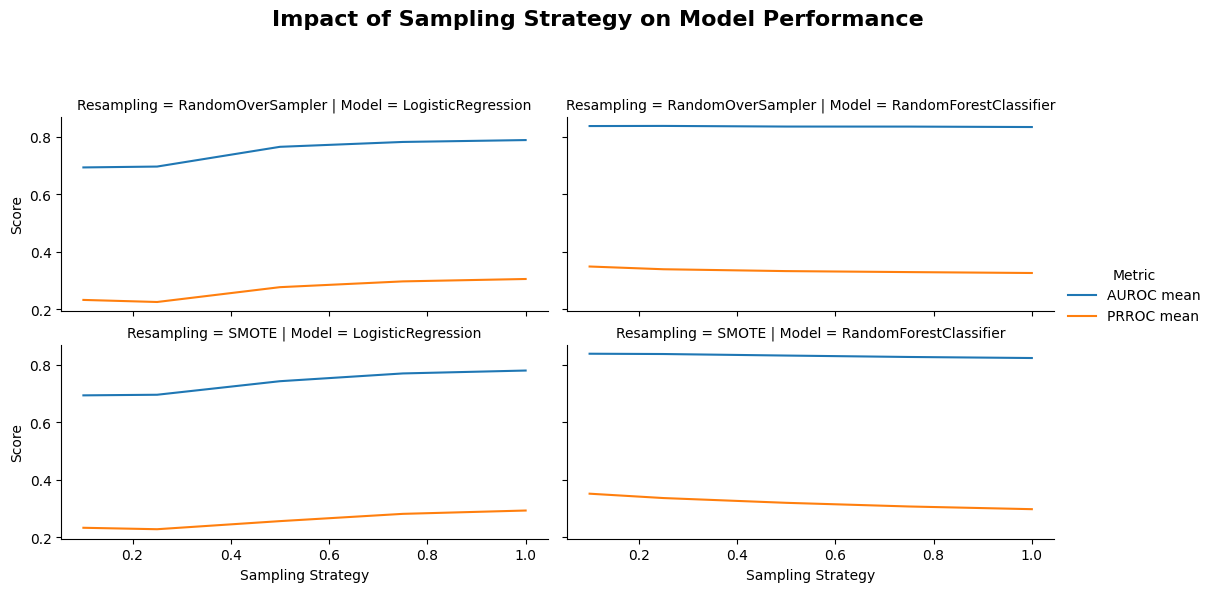

In [167]:
g = sns.relplot(
    data=df_long,
    kind='line',
    x='Sampling Strategy',
    y='Score',
    hue='Metric',
    col='Model',
    row='Resampling',
    height=3,
    aspect=1.8
);

g.figure.suptitle("Impact of Sampling Strategy on Model Performance", fontsize=16, fontweight='bold');
g.figure.subplots_adjust(top=0.8)

In [168]:
# Saving the figure
plt.savefig('results/sampling_strategy_impact.png')

<Figure size 640x480 with 0 Axes>

### **Step 2** for Week 4: Add cost-sensitive baselines (important comparison)
* Logistic Regression (no resampling) with class_weight='balanced'
* Random Forest (no resampling) with class_weight='balanced_subsample'

This will tell us whether the gains from oversampling are basically just "reweighting", which is an important conceptual point for our larger synthetic-data question.

## Extra code from weeks 1 and 2

Below is from week 2, and is currently unused as of week 3

In [103]:
# cv_strategy = RepeatedStratifiedKFold(n_splits=SPLITS, n_repeats=REPEATS,
#                                       random_state=42)

# # Dict to store results of cv tests
# results = {}

# for model in models:
#   model_name = model.__class__.__name__

#   for instance in metadatasets_list:
#     display(f'Currently working on {instance.name} training with {model_name}...')
#     preprocessor = preprocess(num_cols=instance.num_feature_names,
#                               cat_cols=instance.cat_feature_names)

#     model_pipeline = Pipeline(steps=[
#         ("preprocess", preprocessor),
#         ("clf", model)
#     ])

#     scores = cross_val_score(
#         model_pipeline,
#         instance.X_train,
#         instance.y_train,
#         scoring = 'roc_auc',
#         cv=cv_strategy,
#         n_jobs=-1
#     )

#     mean_score = np.mean(scores)

#     if instance.name not in results:
#             results[instance.name] = {}
#     results[instance.name][model_name] = mean_score

# pd.DataFrame(results)